# Warehouse Robot on a Slippery Floor

<a class="anchor" id="Toc"><a>
# Table of Content
1. [Install libraries](#install_libraries)
1. [Import libraries](#import_libraries)
1. [Create and Inspect](#create_and_inspect)
1. [Q-Learning Implementation](#q_learning_implementation)
1. [Training Q-Learning Agent](#q_learning_training)
1. [Evaluation](#evaluation)
1. [Optimization](#optimization)


<a class="anchor" id="install_libraries"></a>
# Install libraries

In [2]:
#pip install gymnasium pygame numpy matplotlib

<a class="anchor" id="import_libraries"></a>
# Import libraries

In [ ]:
import numpy as np  
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.display import display, clear_output
import time
import networkx as nx
from gymnasium.envs.toy_text.frozen_lake import MAPS as FROZEN_LAKE_MAPS


<a class='anchor' id='create_and_inspect'></a>
# Create and Inspect

In [4]:
# Initialize the environment
def get_env(env_name: str, map_name: str, is_slippery: bool, render_mode: str):
    env = gym.make(env_name, map_name=map_name, is_slippery=is_slippery, render_mode=render_mode)
    return env

env = get_env("FrozenLake-v1", "8x8", True, "ansi") # when slippery is True, the agent may not move in the intended direction add randomness to the environment

# basic info
env.reset()
print(env.render())
print("Action space size:", env.action_space.n)
print("Observation space size:", env.observation_space.n)


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Action space size: 4
Observation space size: 64


We are going to use the built inn reward system inn Gym's environment where:
- Move to a Frozen tile(F) give 0 reward
- Fall into a Hole(H) give 0 reward and end the episode
- Reaching the Goal(G) give reward 1 and end the episode

Episode finished with reward: 0


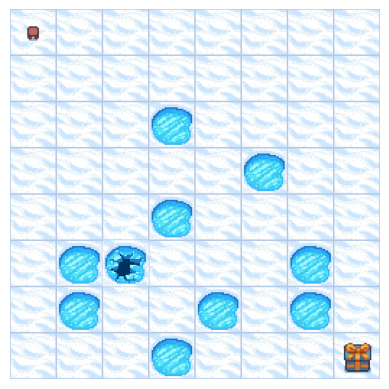

In [5]:
# Test and Visualize a random episode
def run_random_episode(env):
    plt.ion()
    animation_speed = 0.5  # seconds between frames
    state, info = env.reset()
    done = False
    step_count = 0
    while not done:
        step_count += 1
        action = env.action_space.sample()  # Take a random action
        state, reward, done, truncated, info = env.step(action)
        img = env.render()
        plt.imshow(img)
        plt.axis('off')
        clear_output(wait=True)
        display(plt.gcf())
        time.sleep(animation_speed)
        if done:
            clear_output(wait=False)
        if step_count > 30:  # Prevent infinite loops
            print("Episode terminated after 30 steps.")
            break
    print(f"Episode finished with reward: {reward}")

env = get_env("FrozenLake-v1", "8x8", True, "rgb_array")

run_random_episode(env)

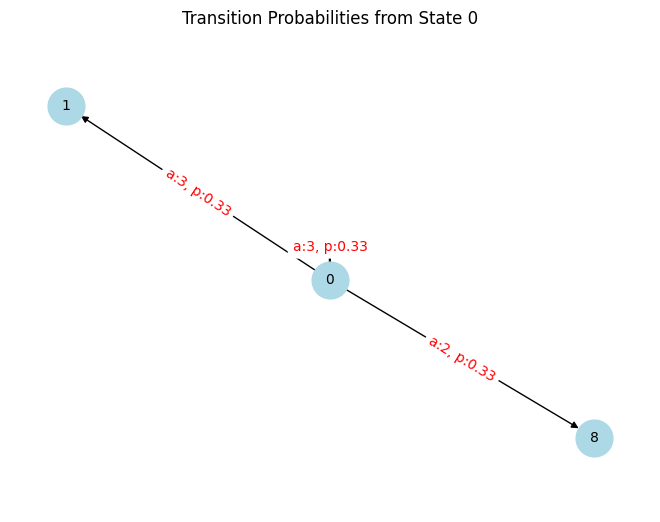

In [6]:
def inspect_transition_probabilities(env, state: int):
    env_raw = env.unwrapped
    G = nx.DiGraph()
    for action in range(env.action_space.n):
        transitions = env_raw.P[state][action]
        for prob, next_state, reward, done in transitions:
            if prob > 0:
                G.add_edge(state, next_state, action=action, weight=prob)
    pos = nx.spring_layout(G)
    edge_labels = {(u, v): f"a:{d['action']}, p:{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title(f"Transition Probabilities from State {state}")
    plt.show()
inspect_transition_probabilities(env, state=0)

<a class="anchor" id="q_learning_implementation"></a>
# Q-Learning Implementation

In [7]:
# intialize the Q-table 
n_states = env.observation_space.n
n_actions = env.action_space.n

Q_table = np.zeros((n_states, n_actions))
print("Q table shape:")
print(Q_table.shape)

Q table shape:
(64, 4)


In [8]:
# define ε-greedy action policy
def epsilon_greedy_policy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Explore: select a random action
    else:
        return np.argmax(Q[state])  # Exploit: select the action with max value (greedy)

### Q-Learning Update Rule

The Q-learning update rule is defined as:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$

####  Variable Definitions

- \( Q(s, a) \): Estimated value of taking action \( a \) in state \( s \).
- \( \alpha \): Learning rate (how quickly the agent updates its knowledge).
- \( r \): Reward received after taking action \( a \) in state \( s \).
- \( \gamma \): Discount factor (how much future rewards are valued).
- \( \max_{a'} Q(s', a') \): Maximum estimated value of the next state \( s' \), over all possible actions \( a' \).
- \( s \): Current state.
- \( a \): Action taken in state \( s \).
- \( s' \): Next state after taking action \( a \).
- \( a' \): A possible action in the next state \( s' \).

In [9]:
def q_update(Q: np.ndarray, state: int, action: int, reward: float, next_state: int, alpha: float, gamma: float, done: bool):
    # target = r + γ max_a' Q(s', a')
    target = reward + gamma * np.max(Q[next_state])*(not done)
    Q[state][action] += alpha * (target - Q[state][action])

Q-table after this episode:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Total reward this episode: 0


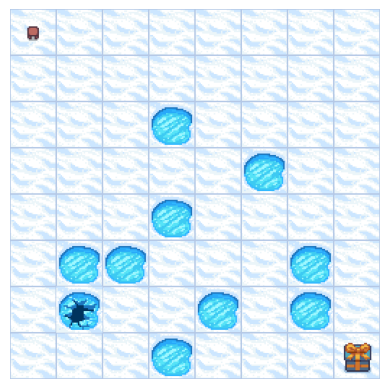

In [10]:
# run a single Q-learning episode
def run_q_learning_episode(env, Q, alpha, gamma, epsilon):
    state, info = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = epsilon_greedy_policy(Q, state, epsilon) # select action
        next_state, reward, done, truncated, info = env.step(action)

        # perform Q-value update
        q_update(Q, state, action, reward, next_state, alpha, gamma, done)
        state = next_state
        total_reward += reward

        #visualization
        img = env.render()
        plt.imshow(img)
        plt.axis('off')
        clear_output(wait=True)
        display(plt.gcf())
        time.sleep(0.3)
        if done:
            clear_output(wait=False)

    print("Q-table after this episode:") # show first 5 states' action values
    print(Q[:5])
    return print("Total reward this episode:", total_reward)
run_q_learning_episode(env, Q_table, alpha=0.8, gamma=0.99, epsilon=0.1)

<a class="anchor" id="q_learning_training"></a>
# Training Q-Learning Agent
Goal

- Run multiple episodes to train the agent:

- Use the ε-greedy policy from before.

- Add ε decay (less exploration over time).

- Update the Q-table after every step.

- Track episode returns and success rate


In [11]:
def q_learning_training(env: gym.Env, num_episodes: int, alpha: float, gamma: float, epsilon: float, epsilon_min: float, epsilon_decay: float, visualize: bool = False):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    
    # tracking variables
    rewards = [] # total rewards per episode
    success_flags = [] # 1 if goal reached, else 0

    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = epsilon_greedy_policy(Q, state, epsilon) # ε-greedy action selection
            # Take a step in the environment
            next_state, reward, done, truncated, info = env.step(action)
            # Q-value update
            q_update(Q, state, action, reward, next_state, alpha, gamma, done)
            state = next_state
            total_reward += reward
            # Visualization
            if visualize:
                env.render()
                img = env.render()
                plt.imshow(img) 
                plt.axis('off')
                clear_output(wait=True)
                display(plt.gcf())
                if done:
                    clear_output(wait=False)
        # record results
        rewards.append(total_reward)
        success_flags.append(1 if done and reward > 0 else 0)

        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        
        # Progress printing
        if (episode + 1) % 1000 == 0:
            print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.4f}")

    return Q, rewards, success_flags

# Training the Q-Learning agent
Q_trained, rewards, success_flags = q_learning_training(env, num_episodes=150000, alpha=0.8, gamma=0.99, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.9995, visualize=False)

Episode 1000/150000, Total Reward: 0, Epsilon: 0.6065
Episode 2000/150000, Total Reward: 0, Epsilon: 0.3678
Episode 3000/150000, Total Reward: 0, Epsilon: 0.2230
Episode 4000/150000, Total Reward: 0, Epsilon: 0.1353
Episode 5000/150000, Total Reward: 0, Epsilon: 0.1000
Episode 6000/150000, Total Reward: 0, Epsilon: 0.1000
Episode 7000/150000, Total Reward: 0, Epsilon: 0.1000
Episode 8000/150000, Total Reward: 0, Epsilon: 0.1000
Episode 9000/150000, Total Reward: 0, Epsilon: 0.1000
Episode 10000/150000, Total Reward: 0, Epsilon: 0.1000
Episode 11000/150000, Total Reward: 0, Epsilon: 0.1000
Episode 12000/150000, Total Reward: 0, Epsilon: 0.1000
Episode 13000/150000, Total Reward: 1, Epsilon: 0.1000
Episode 14000/150000, Total Reward: 1, Epsilon: 0.1000
Episode 15000/150000, Total Reward: 0, Epsilon: 0.1000
Episode 16000/150000, Total Reward: 0, Epsilon: 0.1000
Episode 17000/150000, Total Reward: 0, Epsilon: 0.1000
Episode 18000/150000, Total Reward: 0, Epsilon: 0.1000
Episode 19000/15000

In [ ]:
# try on 6*6 too

FROZEN_LAKE_MAPS["6x6"] = [
    "SFFFFF",
    "FFFFFF",
    "FFFHFF",
    "FHFHFF",
    "FFFHFF",
    "FFFFFG",
]
env_6x6 = get_env("FrozenLake-v1", "6x6", True, "rgb_array")
Q_trained_6x6, rewards_6x6, success_flags_6x6 = q_learning_training(env_6x6, num_episodes=150000, alpha=0.8, gamma=0.99, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.9995, visualize=False)

Episode 1000/150000, Total Reward: 1, Epsilon: 0.6065
Episode 2000/150000, Total Reward: 0, Epsilon: 0.3678
Episode 3000/150000, Total Reward: 0, Epsilon: 0.2230
Episode 4000/150000, Total Reward: 0, Epsilon: 0.1353
Episode 5000/150000, Total Reward: 0, Epsilon: 0.1000
Episode 6000/150000, Total Reward: 0, Epsilon: 0.1000
Episode 7000/150000, Total Reward: 1, Epsilon: 0.1000
Episode 8000/150000, Total Reward: 0, Epsilon: 0.1000
Episode 9000/150000, Total Reward: 1, Epsilon: 0.1000
Episode 10000/150000, Total Reward: 0, Epsilon: 0.1000
Episode 11000/150000, Total Reward: 0, Epsilon: 0.1000
Episode 12000/150000, Total Reward: 0, Epsilon: 0.1000
Episode 13000/150000, Total Reward: 1, Epsilon: 0.1000
Episode 14000/150000, Total Reward: 1, Epsilon: 0.1000
Episode 15000/150000, Total Reward: 1, Epsilon: 0.1000
Episode 16000/150000, Total Reward: 0, Epsilon: 0.1000
Episode 17000/150000, Total Reward: 1, Epsilon: 0.1000
Episode 18000/150000, Total Reward: 1, Epsilon: 0.1000
Episode 19000/15000

<a class="anchor" id="evaluation"></a>
# Evaluation

<a class="anchor" id="optimization"></a>
# Optimization